In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import time
import ignite
import numpy as np
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from typing import List, Callable
import pickle
import tqdm
import pytorch_lightning as pl
import torchmetrics
import os.path
import cv2
import csv
import pandas as pd
#from google.colab import drive
#from google.colab.patches import cv2_imshow
import fnmatch
from math import sqrt
from PIL import Image
import joblib
from torch_lr_finder import LRFinder
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import datetime

In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.8.1+cu101


## Parameters

In [4]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
WD = 1e-4

## Data Classes

In [6]:
# Modificamos la carpeta 
print(os.getcwd())
try:
    print(os.listdir("Pruebas ImitAI"))
    os.chdir("Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco")
except:
    print(os.listdir("../../Pruebas ImitAI"))
    os.chdir("../../Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco")
#os.chdir("../Prueba")
os.listdir()

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco
['2000 pruebas', '2000_Pruebas', 'MuJoCo_Dataset', 'Dataset_Mujoco', 'MuJoCo_100_1']


['Train_dataset', 'Test_dataset', 'MinMax_scaler.save', 'CP', 'CP2']

In [7]:
def red_merge(carpeta_imagenes):
    
    length = len(fnmatch.filter(os.listdir(carpeta_imagenes + "Top/"), '*.png'))
    path = carpeta_imagenes + "Top/0.png"
    img = cv2.imread(path,1)
    aux = np.zeros(np.shape(img))
    
    for idx in range(length):
        path = carpeta_imagenes + "Top/" + str(idx) + ".png"

        #blurring and smoothin
        img=cv2.imread(path,1)

        hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        lower_red = np.array([0,50,50])
        upper_red = np.array([10,255,255])

        mask = cv2.inRange(hsv, lower_red, upper_red)
        res = cv2.bitwise_and(img,img, mask= mask)

        aux = aux + res
    return aux
'''
res = red_merge("Train_dataset/")
cv2_imshow(res)'''

'\nres = red_merge("Train_dataset/")\ncv2_imshow(res)'

In [8]:
os.getcwd()

'/home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco'

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco


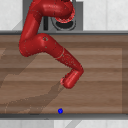

CPU times: user 184 ms, sys: 95.3 ms, total: 279 ms
Wall time: 700 ms


In [9]:
%%time
print(os.getcwd())
for i in range(1000):
    im = Image.open("Test_dataset/Top/"+str(i)+".png")
display(im)

In [10]:
%%time
print(os.getcwd())
for i in range(1000):
    image = cv2.imread("Test_dataset/Top/"+str(i)+".png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#cv2_imshow(image)

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco
CPU times: user 894 ms, sys: 69.7 ms, total: 964 ms
Wall time: 977 ms


### Normalizamos las acciones y obtenemos el array de tamaños

In [11]:
print(os.getcwd())
print(os.listdir())

# Velocities
with open('Train_dataset/Train_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Train_dataset/Train_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3")

with open('Test_dataset/Test_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Test_dataset/Test_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3")

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco
['Train_dataset', 'Test_dataset', 'MinMax_scaler.save', 'CP', 'CP2']


In [12]:
scaler_filename = "MinMax_scaler.save"
scaler_to_save = MinMaxScaler(feature_range=(-1, 1))
joblib.dump(scaler_to_save, scaler_filename) 
scaler_loaded = joblib.load(scaler_filename)

In [13]:
'''
t_list = ["Train_dataset", "Test_dataset"]
ty_list = ["Top", "Corner", "Corner2", "Corner3", "Gripper", "BehindGripper"]
count = 0
for t in t_list:
    for ty in ty_list:
        f = str(t + "/" + ty)
        print(f)
        for file in os.listdir(f):
            f_img = f+"/"+file
            img = Image.open(f_img)
            img = img.resize((128,128))
            img.save(f_img)
            count += 1
            if count % 500 == 0:
                print(count)
'''

'\nt_list = ["Train_dataset", "Test_dataset"]\nty_list = ["Top", "Corner", "Corner2", "Corner3", "Gripper", "BehindGripper"]\ncount = 0\nfor t in t_list:\n    for ty in ty_list:\n        f = str(t + "/" + ty)\n        print(f)\n        for file in os.listdir(f):\n            f_img = f+"/"+file\n            img = Image.open(f_img)\n            img = img.resize((128,128))\n            img.save(f_img)\n            count += 1\n            if count % 500 == 0:\n                print(count)\n'

In [16]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Top/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Top/" + str(idx) + ".png"
        path_2 = self.carpeta_imagenes + "Corner/" + str(idx) + ".png"
        path_3 = self.carpeta_imagenes + "Corner2/" + str(idx) + ".png"
        path_4 = self.carpeta_imagenes + "Corner3/" + str(idx) + ".png"
        path_5 = self.carpeta_imagenes + "Gripper/" + str(idx) + ".png"
        path_6 = self.carpeta_imagenes + "BehindGripper/" + str(idx) + ".png"
        
        im1 = np.array(Image.open(path_1))
        im2 = np.array(Image.open(path_2))
        im3 = np.array(Image.open(path_3))
        im4 = np.array(Image.open(path_4))
        im5 = np.array(Image.open(path_5))
        im6 = np.array(Image.open(path_6))
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = None)
        action = np.float32(np.array(data.iloc[idx]))
        
        if (idx % 25 == 0):
            
            action_prev_1 = np.array([0,0,0,0], dtype="float32")
            action_prev_2 = np.array([0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
            im_t = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_1 = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_2 = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_3 = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_4 = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_5 = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            
        elif ((idx-1) % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.array([0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
            im7 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-1) + ".png"))
            im8 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-1) + ".png"))
            im9 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-1) + ".png"))
            im10 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-1) + ".png"))
            im11 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-1) + ".png"))
            im12 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-1) + ".png"))
            
            im_t = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_1 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_2 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_3 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_4 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_5 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            
        elif ((idx-2)  % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.array([0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
            im7 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-1) + ".png"))
            im8 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-1) + ".png"))
            im9 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-1) + ".png"))
            im10 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-1) + ".png"))
            im11 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-1) + ".png"))
            im12 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-1) + ".png"))
            
            im13 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-2) + ".png"))
            im14 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-2) + ".png"))
            im15 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-2) + ".png"))
            im16 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-2) + ".png"))
            im17 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-2) + ".png"))
            im18 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-2) + ".png"))
            
            im_t = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_1 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_2 = np.concatenate((im13, im14, im15, im16, im17, im18), axis=2)
            im_prev_3 = np.concatenate((im13, im14, im15, im16, im17, im18), axis=2)
            im_prev_4 = np.concatenate((im13, im14, im15, im16, im17, im18), axis=2)
            im_prev_5 = np.concatenate((im13, im14, im15, im16, im17, im18), axis=2)
            
        elif ((idx-3)  % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
            im7 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-1) + ".png"))
            im8 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-1) + ".png"))
            im9 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-1) + ".png"))
            im10 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-1) + ".png"))
            im11 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-1) + ".png"))
            im12 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-1) + ".png"))
            
            im13 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-2) + ".png"))
            im14 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-2) + ".png"))
            im15 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-2) + ".png"))
            im16 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-2) + ".png"))
            im17 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-2) + ".png"))
            im18 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-2) + ".png"))
            
            im19 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-3) + ".png"))
            im20 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-3) + ".png"))
            im21 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-3) + ".png"))
            im22 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-3) + ".png"))
            im23 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-3) + ".png"))
            im24 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-3) + ".png"))
            
            im_t = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_1 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_2 = np.concatenate((im13, im14, im15, im16, im17, im18), axis=2)
            im_prev_3 = np.concatenate((im19, im20, im21, im22, im23, im24), axis=2)
            im_prev_4 = np.concatenate((im19, im20, im21, im22, im23, im24), axis=2)
            im_prev_5 = np.concatenate((im19, im20, im21, im22, im23, im24), axis=2)
            
        elif ((idx-4) % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
            im7 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-1) + ".png"))
            im8 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-1) + ".png"))
            im9 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-1) + ".png"))
            im10 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-1) + ".png"))
            im11 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-1) + ".png"))
            im12 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-1) + ".png"))
            
            im13 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-2) + ".png"))
            im14 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-2) + ".png"))
            im15 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-2) + ".png"))
            im16 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-2) + ".png"))
            im17 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-2) + ".png"))
            im18 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-2) + ".png"))
            
            im19 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-3) + ".png"))
            im20 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-3) + ".png"))
            im21 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-3) + ".png"))
            im22 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-3) + ".png"))
            im23 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-3) + ".png"))
            im24 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-3) + ".png"))
            
            im25 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-4) + ".png"))
            im26 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-4) + ".png"))
            im27 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-4) + ".png"))
            im28 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-4) + ".png"))
            im29 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-4) + ".png"))
            im30 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-4) + ".png"))
            
            im_t = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_1 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_2 = np.concatenate((im13, im14, im15, im16, im17, im18), axis=2)
            im_prev_3 = np.concatenate((im19, im20, im21, im22, im23, im24), axis=2)
            im_prev_4 = np.concatenate((im25, im26, im27, im28, im29, im30), axis=2)
            im_prev_5 = np.concatenate((im25, im26, im27, im28, im29, im30), axis=2)
            
        else:
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.float32(np.array(data.iloc[idx-5]))
            
            im7 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-1) + ".png"))
            im8 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-1) + ".png"))
            im9 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-1) + ".png"))
            im10 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-1) + ".png"))
            im11 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-1) + ".png"))
            im12 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-1) + ".png"))
            
            im13 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-2) + ".png"))
            im14 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-2) + ".png"))
            im15 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-2) + ".png"))
            im16 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-2) + ".png"))
            im17 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-2) + ".png"))
            im18 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-2) + ".png"))
            
            im19 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-3) + ".png"))
            im20 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-3) + ".png"))
            im21 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-3) + ".png"))
            im22 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-3) + ".png"))
            im23 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-3) + ".png"))
            im24 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-3) + ".png"))
            
            im25 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-4) + ".png"))
            im26 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-4) + ".png"))
            im27 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-4) + ".png"))
            im28 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-4) + ".png"))
            im29 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-4) + ".png"))
            im30 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-4) + ".png"))
            
            im31 = np.array(Image.open(self.carpeta_imagenes + "Top/" + str(idx-5) + ".png"))
            im32 = np.array(Image.open(self.carpeta_imagenes + "Corner/" + str(idx-5) + ".png"))
            im33 = np.array(Image.open(self.carpeta_imagenes + "Corner2/" + str(idx-5) + ".png"))
            im34 = np.array(Image.open(self.carpeta_imagenes + "Corner3/" + str(idx-5) + ".png"))
            im35 = np.array(Image.open(self.carpeta_imagenes + "Gripper/" + str(idx-5) + ".png"))
            im36 = np.array(Image.open(self.carpeta_imagenes + "BehindGripper/" + str(idx-5) + ".png"))
            
            im_t = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
            im_prev_1 = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
            im_prev_2 = np.concatenate((im13, im14, im15, im16, im17, im18), axis=2)
            im_prev_3 = np.concatenate((im19, im20, im21, im22, im23, im24), axis=2)
            im_prev_4 = np.concatenate((im25, im26, im27, im28, im29, im30), axis=2)
            im_prev_5 = np.concatenate((im31, im32, im33, im34, im35, im36), axis=2)
            
        #im_actual = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
        #im_previa = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
        #imagen = np.concatenate((im_t, im_prev_1), axis=2) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        # Return both image and action
        return im_t, im_prev_1, im_prev_2, im_prev_3, im_prev_4, im_prev_5, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im_t, im_prev_1, im_prev_2, im_prev_3, im_prev_4, im_prev_5, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5 = self.obs_action_getter[idx]
        for t in self.transformations:
            im_t = t(im_t)
            im_prev_1 = t(im_prev_1)
            im_prev_2 = t(im_prev_2)
            im_prev_3 = t(im_prev_3)
            im_prev_4 = t(im_prev_4)
            im_prev_5 = t(im_prev_5)
        # Return both image and action
        return (im_t, im_prev_1, im_prev_2, im_prev_3, im_prev_4, im_prev_5, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf, lstm, num_layers, hidden):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.lstm = lstm
        self.num_layers = num_layers
        self.hidden = hidden
        
    def forward(self, x):
        x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11 = x
        
        #LSTM
        f1 = self.flatten(self.avg_pool(self.fe(x1)))
        f2 = self.flatten(self.avg_pool(self.fe(x2)))
        f3 = self.flatten(self.avg_pool(self.fe(x3)))
        f4 = self.flatten(self.avg_pool(self.fe(x4)))
        f5 = self.flatten(self.avg_pool(self.fe(x5)))
        f6 = self.flatten(self.avg_pool(self.fe(x6)))
        
        aux = [torch.cat((f2, x7), 1), torch.cat((f3, x8), 1), torch.cat((f4, x9), 1), torch.cat((f5, x10), 1), torch.cat((f6, x11), 1)]
        
        inputs = torch.zeros(len(aux), np.shape(aux[0])[0], np.shape(aux[0])[1])
        for i in range(np.shape(inputs)[0]):
            inputs[i] = aux[i]
        if np.shape(aux[0])[0] == 32:
            xlstm = self.lstm(inputs.cuda(), self.hidden)[0][-1]
        else: 
            hidden = (torch.randn(self.num_layers, np.shape(aux[0])[0], np.shape(aux[0])[1]).cuda(), torch.randn(self.num_layers, np.shape(aux[0])[0], np.shape(aux[0])[1]).cuda())
            xlstm = self.lstm(inputs.cuda(), hidden)[0][-1]
        
        xlstm = torch.squeeze(xlstm)
        f = torch.cat((f1, xlstm), dim=1)
        return self.clf(f)

In [17]:
print(len(fnmatch.filter(os.listdir('Test_dataset/Top'), '*.png')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Corner'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Corner2'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Corner3'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Gripper'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/BehindGripper'), '*')))

print(len(fnmatch.filter(os.listdir('Train_dataset/Top'), '*.png')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Corner'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Corner2'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Corner3'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Gripper'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/BehindGripper'), '*')))

10500
10500
10500
10500
10500
10500
42000
42000
42000
42000
42000
42000


In [18]:
# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions.csv')
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225,
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions.csv')
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225,
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
                                ])

In [19]:
%%time
# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

42000
1312
10500
329
CPU times: user 156 ms, sys: 52.8 ms, total: 209 ms
Wall time: 208 ms


In [20]:
'''
for i in range(30,34):
    print("\nAccion Actual:", train_obs_action_getter[i][1])
    print("Accion Previa - 1:", train_obs_action_getter[i][2])
    print("Accion Previa - 2:", train_obs_action_getter[i][3])
    print("Accion Previa - 3:", train_obs_action_getter[i][4])
    print("Accion Previa - 4:", train_obs_action_getter[i][5])
    print("Accion Previa - 5:", train_obs_action_getter[i][6])
    '''

'\nfor i in range(30,34):\n    print("\nAccion Actual:", train_obs_action_getter[i][1])\n    print("Accion Previa - 1:", train_obs_action_getter[i][2])\n    print("Accion Previa - 2:", train_obs_action_getter[i][3])\n    print("Accion Previa - 3:", train_obs_action_getter[i][4])\n    print("Accion Previa - 4:", train_obs_action_getter[i][5])\n    print("Accion Previa - 5:", train_obs_action_getter[i][6])\n    '

In [21]:
it = iter(test_loader)
first = next(it)
second = next(it)
print(it)

In [22]:
resultados = pd.DataFrame(columns=['Fecha', 'Modelo', 'Imagenes', 'Acciones', 'Batch_size', 'Epochs', 'Prediccion', 'Comentario', 'RMSE', 'EjeX', 'EjeY', 'EjeZ', 'AccSim'])

resultados.to_csv('resultados.csv')  


## Model

We use a pretrained ResNet18 for now. We have to remove the classifier head because it is traiend for classification with 1000 classes. We add a custom head to make regression of 7 values

In [23]:
# To pretrain
model = models.resnet18(pretrained=False)

# Change the first convolution
new_conv = torch.nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = list(model.children())[1:]
model = [new_conv] + model
model = torch.nn.Sequential(*model)

# Get only the feature extractor (remove avgpool and fc layers)
fe = nn.Sequential(*list(model.children())[:-2])

def freeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(False)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(False)
            
def unfreeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(True)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(True)
            
# Freeze all but BatchNorm layers of feature extractor
# Uriz: if we use the "normal" ResNet use the pretained version and freeze all but BN
#       only set all trainiable when we change the fitst convolution layer to accept images of 6 dimensions
#       if the ResNet is pretrained and freezed the training accuracy is maintained (or increased) and the train time is dreceased
fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

# Create custom head
head_clf = nn.Sequential(
    nn.BatchNorm1d(512+512+4),
    nn.Dropout(0.25),
    nn.Linear(512+512+4, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 4)
)

num_layers = 10
dropout = 0.2
bidirectional = False
hidden = (torch.randn(num_layers, BATCH_SIZE, 512+4).cuda(), torch.randn(num_layers, BATCH_SIZE, 512+4).cuda())
lstm = lstm = nn.LSTM(np.shape(hidden[0])[2], np.shape(hidden[0])[2], num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)

# Rebuild the model
model = MultiImage(fe, head_clf, lstm, num_layers, hidden)

## Train Model

In [24]:
# Create trainable class with Pytorch Lightinng
class LitModel(pl.LightningModule):
    def __init__(self, model, loss_function, total_iterations, lr):
        """
        Constructor of the trainable class
        Args:
            model: PyTorch model
            loss_function: The loss function to use
            total_iterations: The total number of iterations for training (num_batches * num_epochs). Used for
                                LR Schedule
            lr: the max_lr to use for the OneCycleLR policy
        """
        super().__init__()
        # Store params
        self.model = model
        self.loss_function = loss_function
        self.total_iterations = total_iterations
        self.lr = lr
        # For measure the MSE
        self.train_mse = torchmetrics.MeanSquaredError()
        self.valid_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        # Forward method
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.train_mse(prediction, y)
        # Log loss and MSE
        self.log("training_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_mse', self.train_mse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Return Loss for backward
        return loss

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_mse.compute(), logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.valid_mse(prediction, y)
        # Log loss and MSE
        self.log('valid_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_mse', self.valid_mse, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.valid_mse.compute(), logger=True)

    def configure_optimizers(self):
        # Get Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Set OneCycleLR policy
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr,
                                                             total_steps=self.total_iterations),
            'interval': 'step', 'frequency': 1, 'name': 'lr_logger'
        }
        return [optimizer], [lr_scheduler]

In [25]:
class CallbackClass(Callback):
    def __init__(self, what="epochs", verbose=True):
        self.what = what
        self.verbose = verbose
        self.state = {"epochs": 0}
        
    @property
    def state_key(self):
        # note: we do not include `verbose` here on purpose
        return self._generate_state_key(what=self.what)

    def on_train_epoch_end(self, *args, **kwargs):
        e = 0
        if self.what == "epochs":
            self.state["epochs"] += 1
            
        if self.state["epochs"] >= 5:
            for param in pl_model.parameters():
                param.requires_grad = True # Unfreeze
        
        for name, param in pl_model.named_parameters():
            if param.requires_grad:
                e = e+1

    def load_state_dict(self, state_dict):
        self.state.update(state_dict)

    def state_dict(self):
        return self.state.copy()

## Bucle to obtain all the info for differents Epochs

In [27]:
RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

ERROR! Session/line number was not unique in database. History logging moved to new session 858


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.50E-04


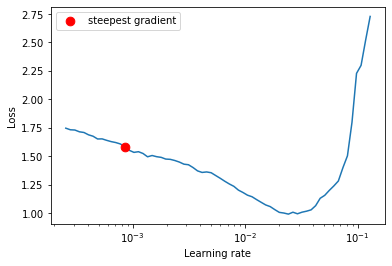

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 33.1 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
21.9 M    Trainable params
11.2 M    Non-trainable params
33.1 M    Total params
132.389   Total estimated model params size (MB)


0.0008497534359086442
EPOCH NUMERO: 20


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

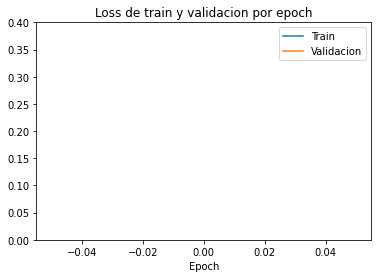

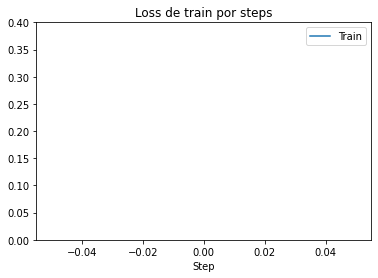

  0%|          | 0/329 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.03226149
El valor RMSE es igual a 0.1796148402049184
[0.1796148402049184]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.42E-02


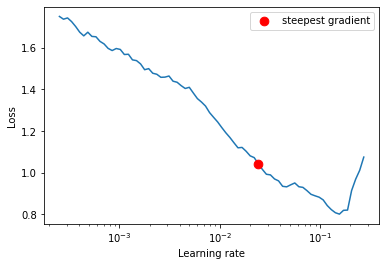

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 33.1 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
21.9 M    Trainable params
11.2 M    Non-trainable params
33.1 M    Total params
132.389   Total estimated model params size (MB)


0.02420128264794381
EPOCH NUMERO: 20


/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco/CP/CP1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_145840/2270487426.py", line 103, in <module>
    PATH_TB = os.listdir("../../../tb_logs/my_model/version_" + str(num))[1]
FileNotFoundError: [Errno 2] No such file or directory: '../../../tb_logs/my_model/version_2'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-package

In [ ]:
Epoch_List = [20]
num = len(os.listdir("../../../tb_logs/my_model"))
wd = [0, 1e-2, 1e-4]
for eps in Epoch_List:
    for weight_d in wd:
    
        # 1 - Se genera la red

        # To pretrain
        model = models.resnet18(pretrained=False)

        # Change the first convolution
        new_conv = torch.nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model = list(model.children())[1:]
        model = [new_conv] + model
        model = torch.nn.Sequential(*model)

        # Get only the feature extractor (remove avgpool and fc layers)
        fe = nn.Sequential(*list(model.children())[:-2])

        fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

        # Create custom head
        head_clf = nn.Sequential(
            nn.BatchNorm1d(512+512+4),
            nn.Dropout(0.25),
            nn.Linear(512+512+4, 512), 
            nn.ReLU(),
            nn.BatchNorm1d(512),   
            nn.Dropout(0.25),
            nn.Linear(512, 4)
        )

        num_layers = 10
        dropout = 0.2
        bidirectional = False
        hidden = (torch.randn(num_layers, BATCH_SIZE, 512+4).cuda(), torch.randn(num_layers, BATCH_SIZE, 512+4).cuda())
        lstm = nn.LSTM(np.shape(hidden[0])[2], np.shape(hidden[0])[2], num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)

        # Rebuild the model
        model = MultiImage(fe, head_clf, lstm, num_layers, hidden)

        # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible

        # Loss function
        criterion = nn.MSELoss()

        # We catch the optimizer of our lit_model
        # optimizer, lr_scheduler = pl_model.configure_optimizers()
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_d)

        # Learning State Finder
        lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
        lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

        # Create trainer class
        try:
            BEST_LR = lr_finder.plot()[1]
        except:
            BEST_LR = 5.0E-03
        print(BEST_LR)

        if BEST_LR > 0.09:
            BEST_LR = 5.0E-03

        # 3 - Se prepara el Trainer y se entrena con el modelo LitModel

        # Number of iterations for LR Schedule
        ITERATIONS_PER_EPOCH = len(train_loader)

        logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model_reg")

        # Create PytorchLighting model for training
        pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

        NUM_GPUS = 1 if torch.cuda.is_available() else 0

        numCP = len(os.listdir("/home/hodei.zia/ImitAI Project/Pruebas ImitAI/MuJoCo_Dataset/CP4/"))

        # Create de ModelCheckpoint
        checkpoint_callback  = pl.callbacks.ModelCheckpoint(dirpath='CP/CP'+str(numCP+1), 
                                                            save_top_k=-1, 
                                                            auto_insert_metric_name=True, 
                                                            every_n_epochs = 1)

        # Create trainer class
        trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                             log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs"), checkpoint_callback], logger=logger)
        #trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
        #                     log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[checkpoint_callback], logger=logger)

        print("EPOCH NUMERO: " + str(eps))

        # Train the model
        trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)

        #num = len(os.listdir("/home/hodei.zia/ImitAI Project/tb_logs/my_model_reg"))
        erroresTrainEpoch=[]
        erroresValEpoch=[]
        erroresTrainStep=[]
        erroresValStep=[]

        PATH_TB = os.listdir("../../../tb_logs/my_model/version_" + str(num))[1]
        PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model/version_" + str(num) + "/"
        path_to_events_file = PATH + PATH_TB
        num = num + 1

        # Plot de LOSS 
        for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
            for v in e.summary.value:
                if v.tag == 'training_loss_epoch':
                    erroresTrainEpoch.append(v.simple_value)
                if v.tag == 'valid_loss_epoch':
                    erroresValEpoch.append(v.simple_value)

                if v.tag == 'training_loss_step':
                    erroresTrainStep.append(v.simple_value)
                #if v.tag == 'valid_loss_step':
                #    erroresValStep.append(v.simple_value)

        plt.plot(erroresTrainEpoch, label='Train')
        plt.plot(erroresValEpoch, label='Validacion')
        plt.title("Loss de train y validacion por epoch")
        plt.xlabel("Epoch")
        plt.ylim(0,0.4)
        plt.legend()
        plt.show()

        plt.plot(erroresTrainStep, label='Train')
        #plt.plot(erroresValStep, label='Validacion')
        plt.title("Loss de train por steps")
        plt.xlabel("Step")
        plt.ylim(0,0.4)
        plt.legend()
        plt.show()

        # 4 - Se predice el resultado

        # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
        model = model.eval()
        # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)

        # To concatenate predictions and labels
        predictions = None
        labels = None
        # Surround all for not computing gradients
        with torch.no_grad():
            # Iterate over test dataset
            for x, y in tqdm.notebook.tqdm(test_loader):
                # Move to device
                x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11 = x
                x1 = x1.to(device)
                x2 = x2.to(device)
                x3 = x3.to(device)
                x4 = x4.to(device)
                x5 = x5.to(device)
                x6 = x6.to(device)
                x7 = x7.to(device)
                x8 = x8.to(device)
                x9 = x9.to(device)
                x10 = x10.to(device)
                x11 = x11.to(device)

                # Predict
                o = model((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11))
                # Concatenate
                if predictions is None:
                    predictions = o
                else:
                    predictions = torch.cat((predictions, o), axis=0)

                if labels is None:
                    labels = y
                else:
                    labels = torch.cat((labels, y), axis=0)

            # Move predictions to CPU and to numpy
            predictions = predictions.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

        mse = sklearn.metrics.mean_squared_error(labels, predictions)
        rmse = sqrt(mse)

        print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
        print("El valor RMSE es igual a " + str(rmse))

        # 5 - Se guardan los resultados 

        RMSE_List.append(rmse)
        Model_List.append(model)
        Prediction_List.append(predictions)
        Label_List.append(labels)
        LR_List.append(BEST_LR)
        #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])

        print(RMSE_List)

ERROR! Session/line number was not unique in database. History logging moved to new session 859


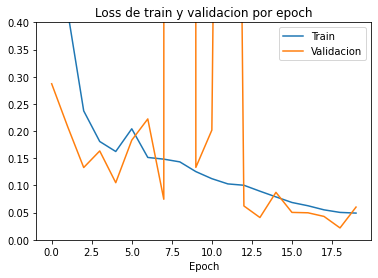

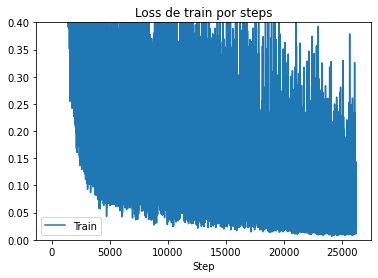

In [28]:
num = len(os.listdir("/home/hodei.zia/ImitAI Project/tb_logs/my_model_reg"))
erroresTrainEpoch=[]
erroresValEpoch=[]
erroresTrainStep=[]
erroresValStep=[]

PATH_TB = os.listdir("/home/hodei.zia/ImitAI Project/tb_logs/my_model_reg/version_" + str(num-1))[0]
PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model_reg/version_" + str(num-1) + "/"
path_to_events_file = PATH + PATH_TB

# Plot de LOSS 
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == 'training_loss_epoch':
            erroresTrainEpoch.append(v.simple_value)
        if v.tag == 'valid_loss_epoch':
            erroresValEpoch.append(v.simple_value)

        if v.tag == 'training_loss_step':
            erroresTrainStep.append(v.simple_value)
        #if v.tag == 'valid_loss_step':
        #    erroresValStep.append(v.simple_value)

plt.plot(erroresTrainEpoch, label='Train')
plt.plot(erroresValEpoch, label='Validacion')
plt.title("Loss de train y validacion por epoch")
plt.xlabel("Epoch")
plt.ylim(0,0.4)
plt.legend()
plt.show()

plt.plot(erroresTrainStep, label='Train')
#plt.plot(erroresValStep, label='Validacion')
plt.title("Loss de train por steps")
plt.xlabel("Step")
plt.ylim(0,0.4)
plt.legend()
plt.show()

In [28]:
'''
print("BEST RMSE: " + str(min(RMSE_List)) + " in Epoch " + 
      str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]) + " with Batch Size = " + str(BATCH_SIZE) + " \nLR = " + 
      str(LR_List[(RMSE_List.index(min(RMSE_List)))]))

# Plot de RMSE-Epoch
plt.plot(Epoch_List, RMSE_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Evolucion del RMSE por Epochs')
plt.show()

# Plot del LR-Epoch
plt.plot(Epoch_List, LR_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Evolucion del LR por Epochs')
plt.show()
'''

'\nprint("BEST RMSE: " + str(min(RMSE_List)) + " in Epoch " + \n      str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]) + " with Batch Size = " + str(BATCH_SIZE) + " \nLR = " + \n      str(LR_List[(RMSE_List.index(min(RMSE_List)))]))\n\n# Plot de RMSE-Epoch\nplt.plot(Epoch_List, RMSE_List, color=\'blue\', linewidth = 3, marker=\'o\', markerfacecolor=\'red\', markersize=12)\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'RMSE\')\nplt.title(\'Evolucion del RMSE por Epochs\')\nplt.show()\n\n# Plot del LR-Epoch\nplt.plot(Epoch_List, LR_List, color=\'blue\', linewidth = 3, marker=\'o\', markerfacecolor=\'red\', markersize=12)\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'LR\')\nplt.title(\'Evolucion del LR por Epochs\')\nplt.show()\n'

## Print the Results

In [29]:
RMSE_List

[0.1796148402049184]

Num Epochs mejor prueba: 20
Weight Decay mejor prueba: 0
RMSE mejor prueba: 0.1796148402049184

Error total por articulacion: [0.06461035 0.23477513 0.26144782]
Eje X [-2.64 - 2.35] 4.99 1.29%
Eje Y [-0.43 - 6.72] 7.15 3.28%
Eje Z [-3.86 - 5.11] 8.97 2.91%
Los valores RMSE por demostracion son igual a [0.19360491065428298, 0.13908625865886987, 0.13445201956445813, 0.16238273988584023, 0.13239637568227922]
El valor medio de RMSE es 0.17173698862611134
El valor maximo de RMSE es 0.40196758574191355 y equivale a la prueba 81
El valor minimo de RMSE es 0.13174723007314276 y equivale a la prueba 32

Mejores RMSE: [0.13174723007314276, 0.1322343316887775, 0.13239637568227922, 0.13306414381797366, 0.13332917187077561]
Mejores pruebas: 32, 54, 4, 7, 60
Comienzan en la imagen: 3200, 5400, 400, 700, 6000

Peores RMSE: [0.40196758574191355, 0.39534797735428945, 0.3819974474784194, 0.3440504278478303, 0.2775005515196191]
Peores pruebas: 81, 76, 62, 70, 48
Comienzan en la imagen: 8100, 7600, 6200, 

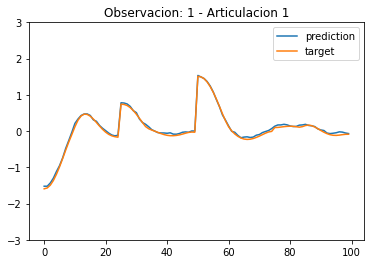

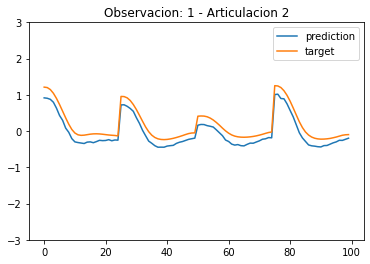

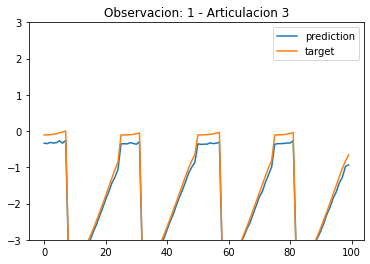

RMSE: 0.40196758574191355


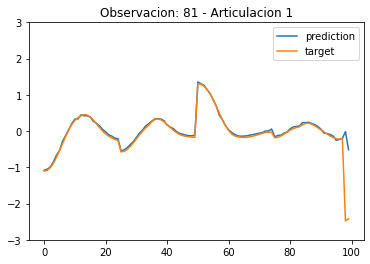

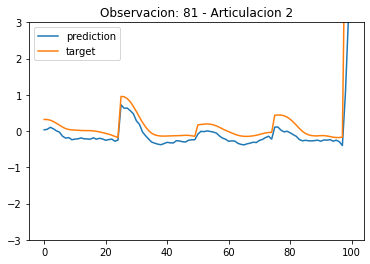

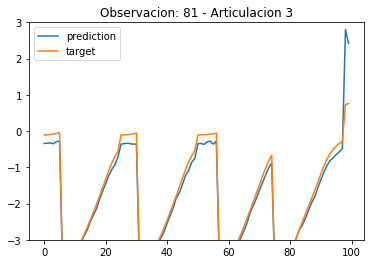

RMSE: 0.13174723007314276


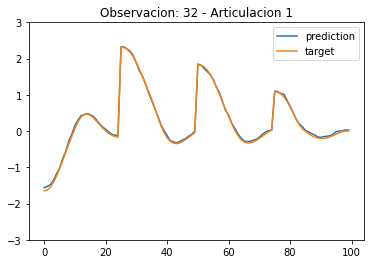

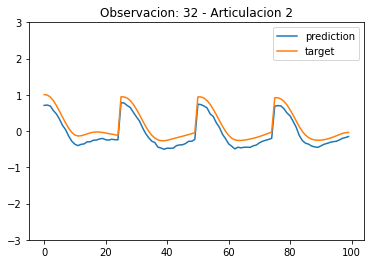

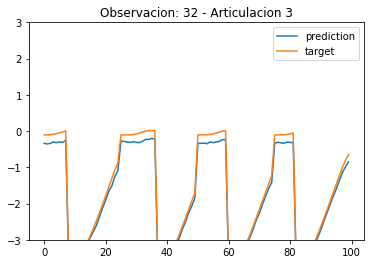

In [30]:
#print(" - Numero de Epoch: " + str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]))
print("Num Epochs mejor prueba: "+str(Epoch_List[0]))
print("Weight Decay mejor prueba: "+str(wd[RMSE_List.index(min(RMSE_List))]))
print("RMSE mejor prueba: "+str(RMSE_List[RMSE_List.index(min(RMSE_List))]))
print("")

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(3)
minimo = np.zeros(3)
maximo = np.zeros(3)
for i in range(3):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print("Error total por articulacion: "+str(joint_error))

ejes = ["X", "Y", "Z"]
for i in range(3):
    print("Eje " + ejes[i] + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(pd.read_csv("Test_dataset/Test_Actions.csv", index_col=0))//100-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[j*100:(j+1)*100], predictions[j*100:(j+1)*100]))
    rmseDem.append(sqrt(mseDem[j]))
    
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor medio de RMSE es "+str(np.mean(rmseDem)))
print("El valor maximo de RMSE es "+str(max(rmseDem))+" y equivale a la prueba "+str(np.argmax(rmseDem)))
print("El valor minimo de RMSE es "+str(min(rmseDem))+" y equivale a la prueba "+str(np.argmin(rmseDem)))
print("")
mRMSE=sorted(rmseDem)[0:5]
print("Mejores RMSE: "+str(mRMSE))
print("Mejores pruebas: "+str(rmseDem.index(mRMSE[0]))+", "+str(rmseDem.index(mRMSE[1]))+", "+str(rmseDem.index(mRMSE[2]))+", "+str(rmseDem.index(mRMSE[3]))+", "+str(rmseDem.index(mRMSE[4])))
print("Comienzan en la imagen: "+str(rmseDem.index(mRMSE[0])*100)+", "+str(rmseDem.index(mRMSE[1])*100)+", "+str(rmseDem.index(mRMSE[2])*100)+", "+str(rmseDem.index(mRMSE[3])*100)+", "+str(rmseDem.index(mRMSE[4])*100))
print("")
pRMSE=sorted(rmseDem,reverse=True)[0:5]
print("Peores RMSE: "+str(pRMSE))
print("Peores pruebas: "+str(rmseDem.index(pRMSE[0]))+", "+str(rmseDem.index(pRMSE[1]))+", "+str(rmseDem.index(pRMSE[2]))+", "+str(rmseDem.index(pRMSE[3]))+", "+str(rmseDem.index(pRMSE[4])))
print("Comienzan en la imagen: "+str(rmseDem.index(pRMSE[0])*100)+", "+str(rmseDem.index(pRMSE[1])*100)+", "+str(rmseDem.index(pRMSE[2])*100)+", "+str(rmseDem.index(pRMSE[3])*100)+", "+str(rmseDem.index(pRMSE[4])*100))
print("")

#Ploteamos la primera prueba
j=1
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[j*100:(j+1)*100], predictions[j*100:(j+1)*100])))
for i in range(3):
    plt.plot(predictions[j*100:(j+1)*100, i], label='prediction')
    plt.plot(labels[j*100:(j+1)*100, i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-3,3)
    plt.legend()
    plt.show()
    
#Ploteamos la peor prueba
j=np.argmax(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[j*100:(j+1)*100], predictions[j*100:(j+1)*100])))
for i in range(3):
    plt.plot(predictions[j*100:(j+1)*100, i], label='prediction')
    plt.plot(labels[j*100:(j+1)*100, i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-3,3)
    plt.legend()
    plt.show()
    
#Ploteamos la mejor prueba
j=np.argmin(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[j*100:(j+1)*100], predictions[j*100:(j+1)*100])))
for i in range(3):
    plt.plot(predictions[j*100:(j+1)*100, i], label='prediction')
    plt.plot(labels[j*100:(j+1)*100, i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-3,3)
    plt.legend()
    plt.show()

## Histrogramas de RMSE por demostraciones Test

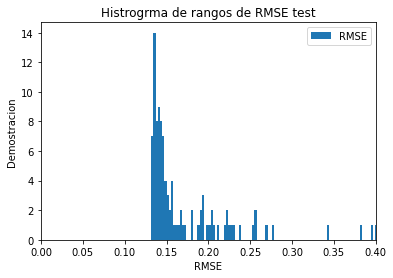

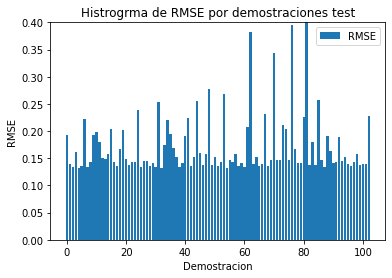

In [31]:
plt.hist(rmseDem,np.shape(rmseDem)[0],label="RMSE")
#plt.bar(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
#plt.plot(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
plt.xlabel('RMSE')
plt.ylabel('Demostracion')
plt.title('Histrogrma de rangos de RMSE test')
plt.xlim(0,0.4)
plt.legend()
plt.show()
#plt.hist(rmseDem,np.shape(rmseDem)[0],label="RMSE")
plt.bar(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
#plt.plot(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
plt.xlabel('Demostracion')
plt.ylabel('RMSE')
plt.title('Histrogrma de RMSE por demostraciones test')
plt.ylim(0,0.4)
plt.legend()
plt.show()

## Save the Results

In [34]:
#Fecha del dia en el que se guarda el modelo
#Nombre del modelo (en formato acordaado en abril)
#Imagenes utilizadas
#Acciones utilizadas
#Batch_size
#Numero de epochs
#Prediccion del modelo
#Explicaciones extras
#RMSE
#Errores de cada Eje
#Accuracy en el simulador
nueva_fila = {'Fecha': datetime.today().strftime('%Y-%m-%d'), 
              'Modelo': "LSTMlmYAc_Reg", 
              'Imagenes': "Hasta T-5", 
              'Acciones': "T-5", 
              'Batch_size': BATCH_SIZE, 
              'Epochs': Epoch_List[0], 
              'Prediccion': "Posicion",
              'Comentario': "Weight_decay "+str(wd[RMSE_List.index(min(RMSE_List))]),
              'RMSE':str(round(RMSE_List[RMSE_List.index(min(RMSE_List))], 6)), 
              'EjeX':str(round(joint_error[0]*100/round(abs(round(minimo[0], 2) - round(maximo[0], 2)),2),2)) + " %", 
              'EjeY':str(round(joint_error[1]*100/round(abs(round(minimo[1], 2) - round(maximo[1], 2)),2),2)) + " %", 
              'EjeZ':str(round(joint_error[2]*100/round(abs(round(minimo[2], 2) - round(maximo[2], 2)),2),2)) + " %", 
              'AccSim':str(round(0/50*100,2)) + " %"}

print(nueva_fila)

{'Fecha': '2022-06-27', 'Modelo': 'LSTMlmYAc_Reg', 'Imagenes': 'Hasta T-5', 'Acciones': 'T-5', 'Batch_size': 32, 'Epochs': 20, 'Prediccion': 'Posicion', 'Comentario': 'Weight_decay 0', 'RMSE': '0.179615', 'EjeX': '1.29 %', 'EjeY': '3.28 %', 'EjeZ': '2.91 %', 'AccSim': '0.0 %'}


In [35]:
df = pd.read_csv("resultados.csv", index_col=0)

df = df.append(nueva_fila, ignore_index=True)
 
print(df)

df.to_csv('resultados.csv') 

        Fecha         Modelo   Imagenes Acciones Batch_size Epochs Prediccion  \
0  2022-06-27  LSTMlmYAc_Reg  Hasta T-5      T-5         32     20   Posicion   

       Comentario      RMSE    EjeX    EjeY    EjeZ AccSim  
0  Weight_decay 0  0.179615  1.29 %  3.28 %  2.91 %  0.0 %  


## Save the Model

In [33]:
print("DATOS DEL MODELO:")
#print(" - Numero de Epoch: " + str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]))
print("Num Epochs mejor prueba: "+str(Epoch_List[0]))
print("Weight Decay mejor prueba: "+str(wd[RMSE_List.index(min(RMSE_List))]))
print(" - RMSE: " + str(min(RMSE_List)))
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)))], 'model_pytorch_01796_LSTMlmYAc_Reg')
model = torch.load('model_pytorch_01796_LSTMlmYAc_Reg')
model.eval()

DATOS DEL MODELO:
Num Epochs mejor prueba: 20
Weight Decay mejor prueba: 0
 - RMSE: 0.1796148402049184


MultiImage(
  (fe): Sequential(
    (0): Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
